In [1]:
import pandas as pd
import numpy as np
import pandas as pd

import fbprophet
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

## Extract data for different Crypto pairs (Source: Binance)

In [2]:
# IMPORTS
import pandas as pd
import math
import os.path
import time
from bitmex import bitmex
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)

In [3]:
### API
bitmex_api_key = 'LyRT8pP8zBEqJt2lPqN1vltAtAIqI2OBoR3fDnT7BFebOXZgoHRKd4aeDCrOjAhM Copy'    #Enter your own API-key here
bitmex_api_secret = 'e0LZ2jjh8GwxaCPdoZf3kOEkDWEkrsSguJbJMJkEeEjvjAfqTyxiXR77zhHmgeYr' #Enter your own API-secret here

binance_api_key = 'LyRT8pP8zBEqJt2lPqN1vltAtAIqI2OBoR3fDnT7BFebOXZgoHRKd4aeDCrOjAhM Copy'    #Enter your own API-key here
binance_api_secret = 'e0LZ2jjh8GwxaCPdoZf3kOEkDWEkrsSguJbJMJkEeEjvjAfqTyxiXR77zhHmgeYr' #Enter your own API-secret here

In [4]:
### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750
bitmex_client = bitmex(test=False, api_key=bitmex_api_key, api_secret=bitmex_api_secret)
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)

/Applications/anaconda3/lib/python3.7/site-packages/swagger_spec_validator/validator20.py:53: SwaggerValidationWarning:

Found "$ref: #/definitions/UserPreferences" with siblings that will be overwritten. See https://stackoverflow.com/a/48114924 for more information. (path #/definitions/User/properties/preferences)



In [5]:
### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2017', '%d %b %Y')
    elif source == "bitmex": old = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=False).result()[0][0]['timestamp']
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    if source == "bitmex": new = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=True).result()[0][0]['timestamp']
    return old, new

In [6]:
def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2017', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

In [7]:
def get_all_bitmex(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "bitmex")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    rounds = math.ceil(available_data / batch_size)
    if rounds > 0:
        print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data in %d rounds.' % (delta_min, symbol, available_data, kline_size, rounds))
        for round_num in tqdm_notebook(range(rounds)):
            time.sleep(1)
            new_time = (oldest_point + timedelta(minutes = round_num * batch_size * binsizes[kline_size]))
            data = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=batch_size, startTime = new_time).result()[0]
            temp_df = pd.DataFrame(data)
            data_df = data_df.append(temp_df)
    data_df.set_index('timestamp', inplace=True)
    if save and rounds > 0: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

In [8]:
df_binance_BTCUSDT = get_all_binance("BTCUSDT","1d",save=False)

df_binance_ETHBTC = get_all_binance("ETHBTC","1d",save=False)
df_binance_ETHUSDT = get_all_binance("ETHUSDT","1d",save=False)
df_binance_ERDBTC = get_all_binance("ERDBTC","1d",save=False)
df_binance_BNBBTC = get_all_binance("BNBBTC","1d",save=False)
#df_binance_BNBBTC.head()

All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!


In [38]:
df_binance_BTCUSDT_close = df_binance_BTCUSDT["close"].reset_index()
df_binance_ETHBTC_close = df_binance_ETHBTC["close"].reset_index()
df_binance_ETHUSDT_close = df_binance_ETHUSDT["close"].reset_index()
df_binance_ERDBTC_close = df_binance_ERDBTC["close"].reset_index()
df_binance_BNBBTC_close = df_binance_BNBBTC["close"].reset_index()

df_binance_ETHBTC_close.head()

,timestamp,close
0,2017-07-14,0.090993
1,2017-07-15,0.087635
2,2017-07-16,0.082241
3,2017-07-17,0.087537
4,2017-07-18,0.107732


In [39]:
df_binance_BTCUSDT_close["log_y"] = np.log(df_binance_BTCUSDT_close["close"].astype('float64'))
df_binance_ETHBTC_close["log_y"] = np.log(df_binance_ETHBTC_close["close"].astype('float64'))
df_binance_ETHUSDT_close["log_y"] = np.log(df_binance_ETHUSDT_close["close"].astype('float64'))
df_binance_ERDBTC_close["log_y"] = np.log(df_binance_ERDBTC_close["close"].astype('float64'))
df_binance_BNBBTC_close["log_y"] = np.log(df_binance_BNBBTC_close["close"].astype('float64'))

df_binance_ETHBTC_close.head()

,timestamp,close,log_y
0,2017-07-14,0.090993,-2.396973
1,2017-07-15,0.087635,-2.434575
2,2017-07-16,0.082241,-2.498101
3,2017-07-17,0.087537,-2.435694
4,2017-07-18,0.107732,-2.228109


In [40]:
df_binance_BTCUSDT_prophet = df_binance_BTCUSDT_close.rename(columns={'timestamp': 'ds', 'log_y': 'y'})
df_binance_BTCUSDT_prophet['ds'] =pd.to_datetime(df_binance_BTCUSDT_prophet.ds)
df_binance_BTCUSDT_prophet.sort_values(by='ds', inplace = True)

df_binance_ETHBTC_prophet = df_binance_ETHBTC_close.rename(columns={'timestamp': 'ds', 'log_y': 'y'})
df_binance_ETHBTC_prophet['ds'] =pd.to_datetime(df_binance_ETHBTC_prophet.ds)
df_binance_ETHBTC_prophet.sort_values(by='ds', inplace = True)

df_binance_ETHUSDT_prophet = df_binance_ETHUSDT_close.rename(columns={'timestamp': 'ds', 'log_y': 'y'})
df_binance_ETHUSDT_prophet['ds'] =pd.to_datetime(df_binance_ETHUSDT_prophet.ds)
df_binance_ETHUSDT_prophet.sort_values(by='ds', inplace = True)

df_binance_ERDBTC_prophet = df_binance_ERDBTC_close.rename(columns={'timestamp': 'ds', 'log_y': 'y'})
df_binance_ERDBTC_prophet['ds'] =pd.to_datetime(df_binance_ERDBTC_prophet.ds)
df_binance_ERDBTC_prophet.sort_values(by='ds', inplace = True)

df_binance_BNBBTC_prophet = df_binance_BNBBTC_close.rename(columns={'timestamp': 'ds', 'log_y': 'y'})
df_binance_BNBBTC_prophet['ds'] =pd.to_datetime(df_binance_BNBBTC_prophet.ds)
df_binance_BNBBTC_prophet.sort_values(by='ds', inplace = True)

df_binance_ETHBTC_prophet.head()

,ds,close,y
0,2017-07-14,0.090993,-2.396973
1,2017-07-15,0.087635,-2.434575
2,2017-07-16,0.082241,-2.498101
3,2017-07-17,0.087537,-2.435694
4,2017-07-18,0.107732,-2.228109


In [41]:
df_binance_ETHBTC_prophet.shape

(1090, 3)

### 1) BTC-USDT Prophet

#### Tuning Parameter
Changepoints are basically points where the trend makes a sudden change in direction, e.g. reversal. Prophet can find these points for you automatically, although it is possible to define them yourself, though for large and idiosyncratic datasets this is impractical. Hey that’s what machines are for, right? The changepoint_prior_scale parameter basically allows you to choose how tightly you want the changepoints to match the data.

So we will use this one hyperparameter to do all our fine tuning. The higher the value the tighter the fit, and likewise the lower the value the looser the fit. For this demo I have chosen to values (0.0015 and 0.015) separated by an order of magnitude.

In [42]:
priors = [0.0015, 0.015]
prophets_BTCUSDT, labels_BTCUSDT = [], []
for prior in priors:
    prophet = fbprophet.Prophet(changepoint_prior_scale=prior)
    prophet.fit(df_binance_BTCUSDT_prophet)
 
    prophets_BTCUSDT.append(prophet)
    labels_BTCUSDT.append(r"CP Prior = " + str(prior))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Applications/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Applications/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



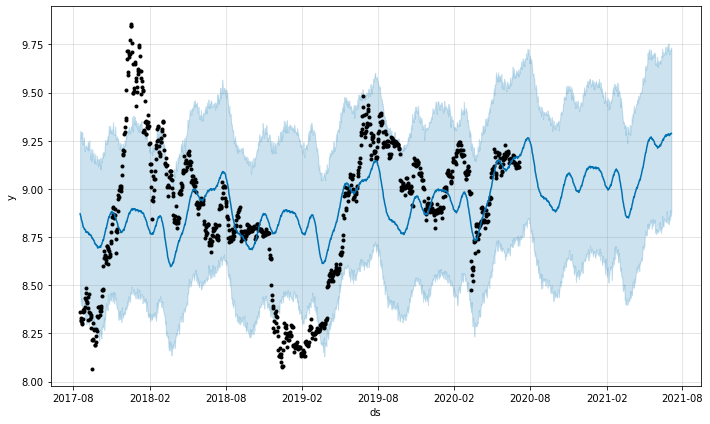

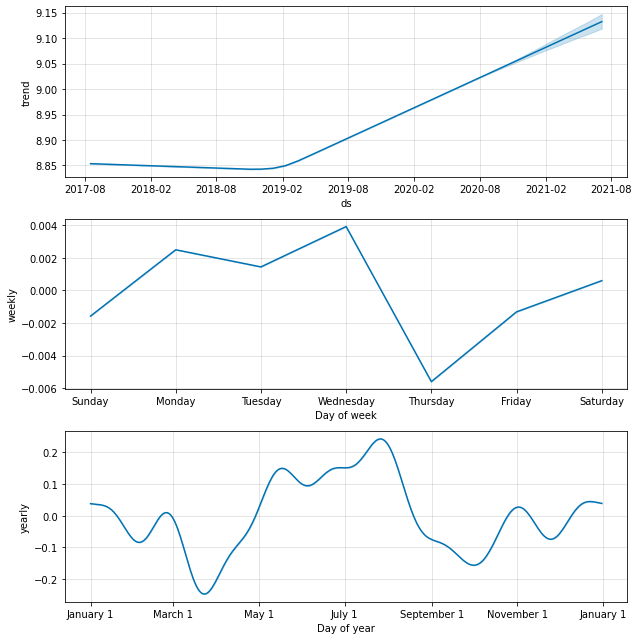

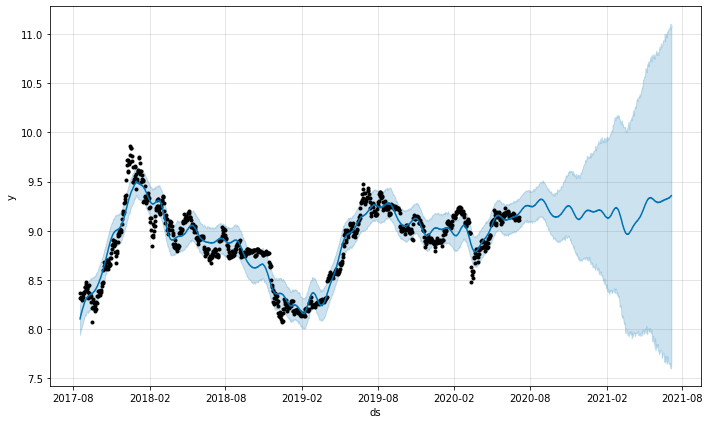

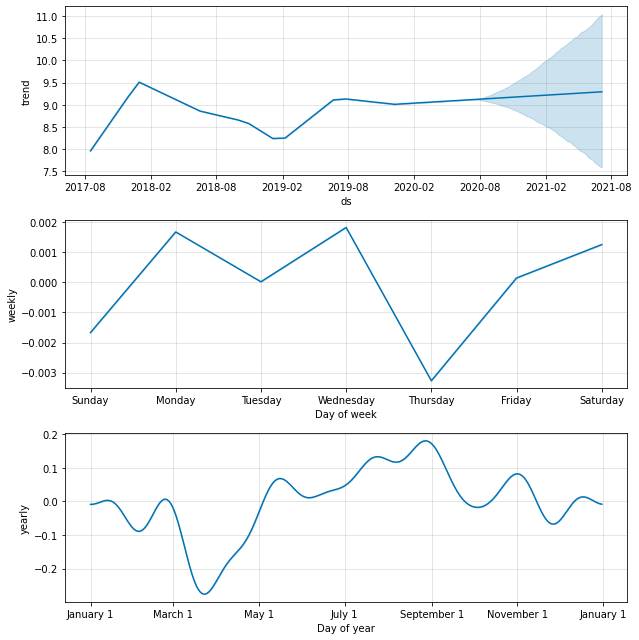

In [43]:
forecasts_BTCUSDT = []
for prophet in prophets_BTCUSDT:
    forecast = prophet.make_future_dataframe(periods=365, freq="D")
    forecast = prophet.predict(forecast)
    
    fig_tune_BTCUSDT = prophet.plot(forecast)
    fig_tune2_BTCUSDT = prophet.plot_components(forecast)
    
    #py.init_notebook_mode()
    #fig_tune3_BTCUSDT = plot_plotly(prophet, forecast)  # This returns a plotly Figure
    #py.iplot(fig_tune3_BTCUSDT)
 
    forecast_rename = forecast.rename(columns={"ds" : str(priors[prophets_BTCUSDT.index(prophet)]) + "_ds"})
    forecasts_BTCUSDT.append(forecast_rename)

In [44]:
#forecasts_BTCUSDT[0].tail()

In [45]:
forecasts_BTCUSDT[1].shape

(1421, 19)

In [46]:
#merge the two datasets and rename the ‘_ds’ columns to ‘Date’ and drop the other.
output_BTCUSDT = pd.merge(forecasts_BTCUSDT[0], forecasts_BTCUSDT[1], how = "inner", left_on = "0.0015_ds", right_on = "0.015_ds")
output_BTCUSDT = output_BTCUSDT.rename(columns={"0.0015_ds": "Date"}).drop("0.015_ds", axis=1)
###output.drop_duplicates("Date", inplace=True)

output_BTCUSDT = output_BTCUSDT.set_index('Date')
#output_BTCUSDT.tail()

In [47]:
output_BTCUSDT.shape

(1423, 36)

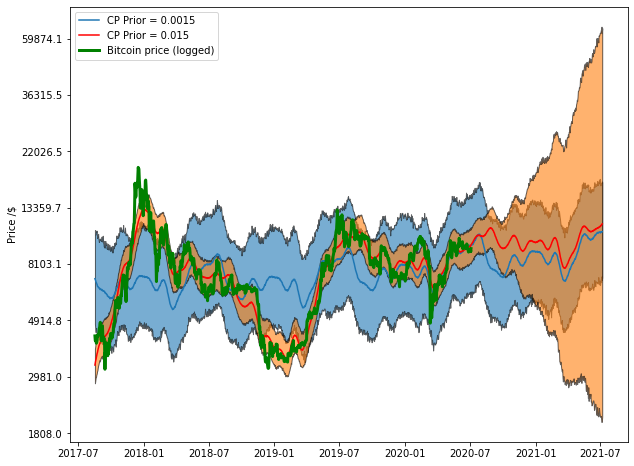

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(output_BTCUSDT.index, output_BTCUSDT["yhat_x"], label=labels_BTCUSDT[0])
ax.fill_between(output_BTCUSDT.index, output_BTCUSDT["yhat_upper_x"], output_BTCUSDT["yhat_lower_x"], alpha=0.6, edgecolor = "k")

ax.plot(output_BTCUSDT.index, output_BTCUSDT["yhat_y"], "r", label=labels_BTCUSDT[1]);
ax.fill_between(output_BTCUSDT.index, output_BTCUSDT["yhat_upper_y"], output_BTCUSDT["yhat_lower_y"], alpha=0.6, edgecolor = "k")

ax.plot(output_BTCUSDT.index[:len(df_binance_BTCUSDT_prophet)], df_binance_BTCUSDT_prophet.y, color="green", linewidth=3, label=r"Bitcoin price (logged)")

a=ax.get_yticks().tolist()
ax.set_yticklabels(np.round(np.exp(a), 1))
plt.legend(loc="upper left")
plt.ylabel(r"Price /$")
plt.show()

### 2) ETH-BTC Prophet

In [13]:
priors = [0.0015, 0.015]
prophets_ETHBTC, labels_ETHBTC = [], []
for prior in priors:
    prophet = fbprophet.Prophet(changepoint_prior_scale=prior)
    prophet.fit(df_binance_ETHBTC_prophet)
 
    prophets_ETHBTC.append(prophet)
    labels_ETHBTC.append(r"CP Prior = " + str(prior))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Applications/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Applications/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



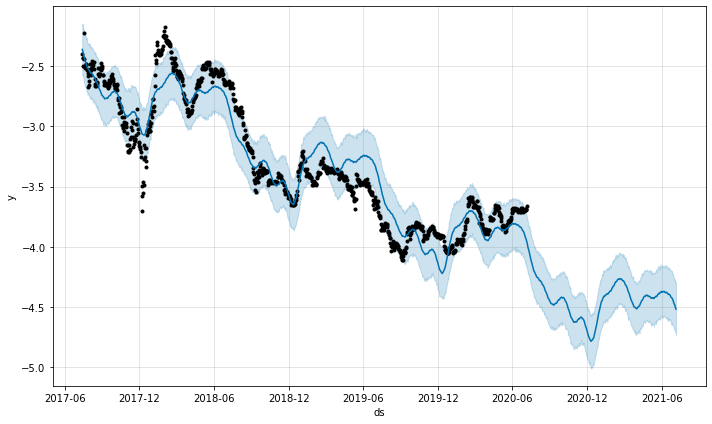

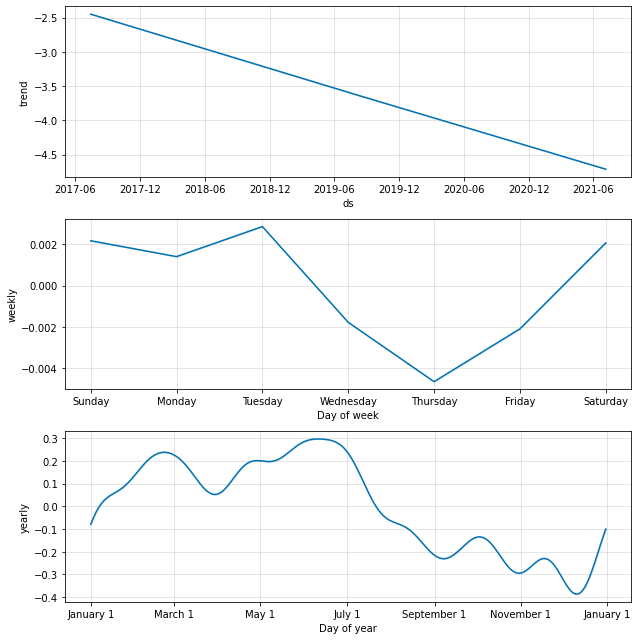

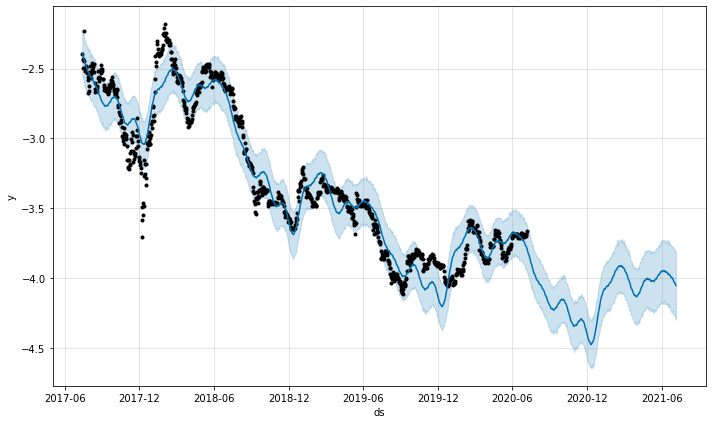

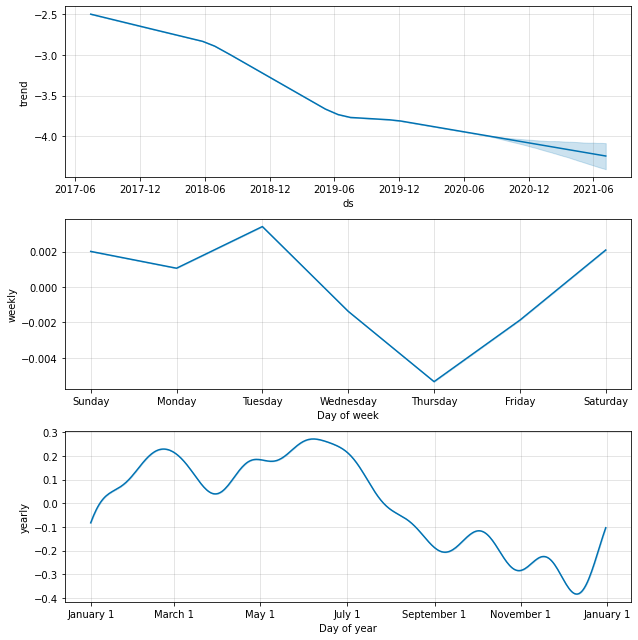

In [49]:
forecasts_ETHBTC = []
for prophet in prophets_ETHBTC:
    forecast = prophet.make_future_dataframe(periods=365, freq="D")
    forecast = prophet.predict(forecast)
    
    fig_tune_ETHBTC = prophet.plot(forecast)
    fig_tune2_ETHBTC = prophet.plot_components(forecast)
    
    #py.init_notebook_mode()
    #fig_tune3_ETHBTC = plot_plotly(prophet, forecast)  # This returns a plotly Figure
    #py.iplot(fig_tune3_ETHBTC)
 
    forecast_rename = forecast.rename(columns={"ds" : str(priors[prophets_ETHBTC.index(prophet)]) + "_ds"})
    forecasts_ETHBTC.append(forecast_rename)

In [15]:
#forecasts_ETHBTC[0].tail()

In [16]:
forecasts_ETHBTC[1].shape

(1455, 19)

In [17]:
#merge the two datasets and rename the ‘_ds’ columns to ‘Date’ and drop the other.
output_ETHBTC = pd.merge(forecasts_ETHBTC[0], forecasts_ETHBTC[1], how = "inner", left_on = "0.0015_ds", right_on = "0.015_ds")
output_ETHBTC = output_ETHBTC.rename(columns={"0.0015_ds": "Date"}).drop("0.015_ds", axis=1)
###output.drop_duplicates("Date", inplace=True)

output_ETHBTC = output_ETHBTC.set_index('Date')
#output_ETHBTC.tail()

In [18]:
output_ETHBTC.shape

(1457, 36)

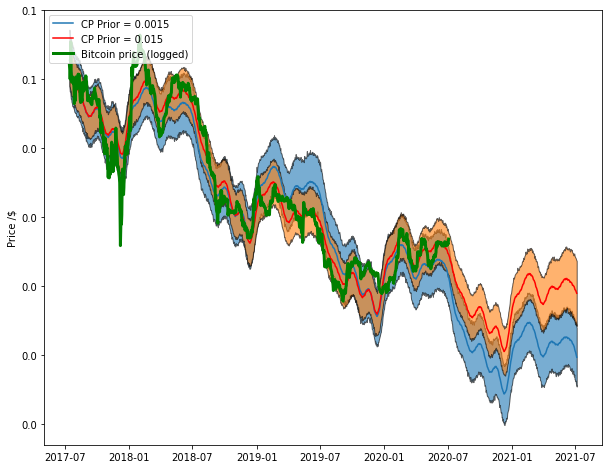

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(output_ETHBTC.index, output_ETHBTC["yhat_x"], label=labels_ETHBTC[0])
ax.fill_between(output_ETHBTC.index, output_ETHBTC["yhat_upper_x"], output_ETHBTC["yhat_lower_x"], alpha=0.6, edgecolor = "k")

ax.plot(output_ETHBTC.index, output_ETHBTC["yhat_y"], "r", label=labels_ETHBTC[1]);
ax.fill_between(output_ETHBTC.index, output_ETHBTC["yhat_upper_y"], output_ETHBTC["yhat_lower_y"], alpha=0.6, edgecolor = "k")

ax.plot(output_ETHBTC.index[:len(df_binance_ETHBTC_prophet)], df_binance_ETHBTC_prophet.y, color="green", linewidth=3, label=r"Bitcoin price (logged)")

a=ax.get_yticks().tolist()
ax.set_yticklabels(np.round(np.exp(a), 1))
plt.legend(loc="upper left")
plt.ylabel(r"Price /$")
plt.show()

### 2) ETHUSDT Prophet

In [20]:
priors = [0.0015, 0.015]
prophets_ETHUSDT, labels_ETHUSDT = [], []
for prior in priors:
    prophet = fbprophet.Prophet(changepoint_prior_scale=prior)
    prophet.fit(df_binance_ETHUSDT_prophet)
 
    prophets_ETHUSDT.append(prophet)
    labels_ETHUSDT.append(r"CP Prior = " + str(prior))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Applications/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Applications/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [21]:
forecasts_ETHUSDT = []
for prophet in prophets_ETHUSDT:
    forecast = prophet.make_future_dataframe(periods=365, freq="D")
    forecast = prophet.predict(forecast)
    
    #fig_tune_ETHUSDT = prophet.plot(forecast)
    #fig_tune2_ETHUSDT = prophet.plot_components(forecast)
    
    #py.init_notebook_mode()
    #fig_tune3_ETHUSDT = plot_plotly(prophet, forecast)  # This returns a plotly Figure
    #py.iplot(fig_tune3_ETHUSDT)
 
    forecast_rename = forecast.rename(columns={"ds" : str(priors[prophets_ETHUSDT.index(prophet)]) + "_ds"})
    forecasts_ETHUSDT.append(forecast_rename)

In [26]:
#merge the two datasets and rename the ‘_ds’ columns to ‘Date’ and drop the other.
output_ETHUSDT = pd.merge(forecasts_ETHUSDT[0], forecasts_ETHUSDT[1], how = "inner", left_on = "0.0015_ds", right_on = "0.015_ds")
output_ETHUSDT = output_ETHUSDT.rename(columns={"0.0015_ds": "Date"}).drop("0.015_ds", axis=1)
###output.drop_duplicates("Date", inplace=True)

output_ETHUSDT = output_ETHUSDT.set_index('Date')
#output_ETHUSDT.tail()

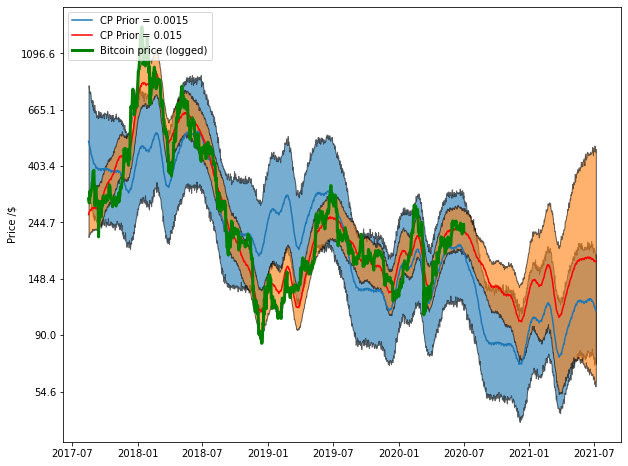

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(output_ETHUSDT.index, output_ETHUSDT["yhat_x"], label=labels_ETHUSDT[0])
ax.fill_between(output_ETHUSDT.index, output_ETHUSDT["yhat_upper_x"], output_ETHUSDT["yhat_lower_x"], alpha=0.6, edgecolor = "k")

ax.plot(output_ETHUSDT.index, output_ETHUSDT["yhat_y"], "r", label=labels_ETHUSDT[1]);
ax.fill_between(output_ETHUSDT.index, output_ETHUSDT["yhat_upper_y"], output_ETHUSDT["yhat_lower_y"], alpha=0.6, edgecolor = "k")

ax.plot(output_ETHUSDT.index[:len(df_binance_ETHUSDT_prophet)], df_binance_ETHUSDT_prophet.y, color="green", linewidth=3, label=r"Bitcoin price (logged)")

a=ax.get_yticks().tolist()
ax.set_yticklabels(np.round(np.exp(a), 1))
plt.legend(loc="upper left")
plt.ylabel(r"Price /$")
plt.show()

### 3) ERDBTC Prophet

In [24]:
priors = [0.0015, 0.015]
prophets_ERDBTC, labels_ERDBTC = [], []
for prior in priors:
    prophet = fbprophet.Prophet(changepoint_prior_scale=prior)
    prophet.fit(df_binance_ERDBTC_prophet)
 
    prophets_ERDBTC.append(prophet)
    labels_ERDBTC.append(r"CP Prior = " + str(prior))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Applications/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Applications/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [25]:
forecasts_ERDBTC = []
for prophet in prophets_ERDBTC:
    forecast = prophet.make_future_dataframe(periods=365, freq="D")
    forecast = prophet.predict(forecast)
    
    #fig_tune_ERDBTC = prophet.plot(forecast)
    #fig_tune2_ERDBTC = prophet.plot_components(forecast)
    
    #py.init_notebook_mode()
    #fig_tune3_ERDBTC = plot_plotly(prophet, forecast)  # This returns a plotly Figure
    #py.iplot(fig_tune3_ERDBTC)
 
    forecast_rename = forecast.rename(columns={"ds" : str(priors[prophets_ERDBTC.index(prophet)]) + "_ds"})
    forecasts_ERDBTC.append(forecast_rename)

In [27]:
#merge the two datasets and rename the ‘_ds’ columns to ‘Date’ and drop the other.
output_ERDBTC = pd.merge(forecasts_ERDBTC[0], forecasts_ERDBTC[1], how = "inner", left_on = "0.0015_ds", right_on = "0.015_ds")
output_ERDBTC = output_ERDBTC.rename(columns={"0.0015_ds": "Date"}).drop("0.015_ds", axis=1)
###output.drop_duplicates("Date", inplace=True)

output_ERDBTC = output_ERDBTC.set_index('Date')
#output_ERDBTC.tail()

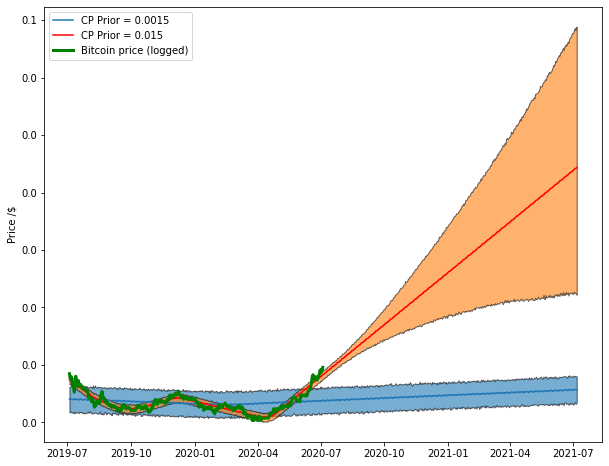

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(output_ERDBTC.index, output_ERDBTC["yhat_x"], label=labels_ERDBTC[0])
ax.fill_between(output_ERDBTC.index, output_ERDBTC["yhat_upper_x"], output_ERDBTC["yhat_lower_x"], alpha=0.6, edgecolor = "k")

ax.plot(output_ERDBTC.index, output_ERDBTC["yhat_y"], "r", label=labels_ERDBTC[1]);
ax.fill_between(output_ERDBTC.index, output_ERDBTC["yhat_upper_y"], output_ERDBTC["yhat_lower_y"], alpha=0.6, edgecolor = "k")

ax.plot(output_ERDBTC.index[:len(df_binance_ERDBTC_prophet)], df_binance_ERDBTC_prophet.y, color="green", linewidth=3, label=r"Bitcoin price (logged)")

a=ax.get_yticks().tolist()
ax.set_yticklabels(np.round(np.exp(a), 1))
plt.legend(loc="upper left")
plt.ylabel(r"Price /$")
plt.show()

### 4) BNBBTC Prophet

In [29]:
priors = [0.0015, 0.015]
prophets_BNBBTC, labels_BNBBTC = [], []
for prior in priors:
    prophet = fbprophet.Prophet(changepoint_prior_scale=prior)
    prophet.fit(df_binance_BNBBTC_prophet)
 
    prophets_BNBBTC.append(prophet)
    labels_BNBBTC.append(r"CP Prior = " + str(prior))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Applications/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Applications/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [30]:
forecasts_BNBBTC = []
for prophet in prophets_BNBBTC:
    forecast = prophet.make_future_dataframe(periods=365, freq="D")
    forecast = prophet.predict(forecast)
    
    #fig_tune_BNBBTC = prophet.plot(forecast)
    #fig_tune2_BNBBTC = prophet.plot_components(forecast)
    
    #py.init_notebook_mode()
    #fig_tune3_BNBBTC = plot_plotly(prophet, forecast)  # This returns a plotly Figure
    #py.iplot(fig_tune3_BNBBTC)
 
    forecast_rename = forecast.rename(columns={"ds" : str(priors[prophets_BNBBTC.index(prophet)]) + "_ds"})
    forecasts_BNBBTC.append(forecast_rename)

In [31]:
#merge the two datasets and rename the ‘_ds’ columns to ‘Date’ and drop the other.
output_BNBBTC = pd.merge(forecasts_BNBBTC[0], forecasts_BNBBTC[1], how = "inner", left_on = "0.0015_ds", right_on = "0.015_ds")
output_BNBBTC = output_BNBBTC.rename(columns={"0.0015_ds": "Date"}).drop("0.015_ds", axis=1)
###output.drop_duplicates("Date", inplace=True)

output_BNBBTC = output_BNBBTC.set_index('Date')
#output_BNBBTC.tail()

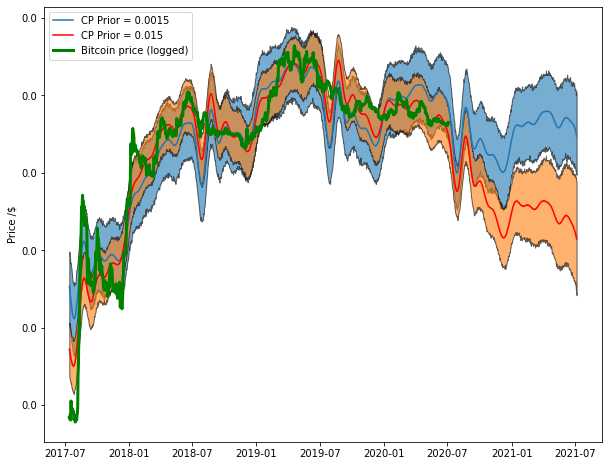

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(output_BNBBTC.index, output_BNBBTC["yhat_x"], label=labels_BNBBTC[0])
ax.fill_between(output_BNBBTC.index, output_BNBBTC["yhat_upper_x"], output_BNBBTC["yhat_lower_x"], alpha=0.6, edgecolor = "k")

ax.plot(output_BNBBTC.index, output_BNBBTC["yhat_y"], "r", label=labels_BNBBTC[1]);
ax.fill_between(output_BNBBTC.index, output_BNBBTC["yhat_upper_y"], output_BNBBTC["yhat_lower_y"], alpha=0.6, edgecolor = "k")

ax.plot(output_BNBBTC.index[:len(df_binance_BNBBTC_prophet)], df_binance_BNBBTC_prophet.y, color="green", linewidth=3, label=r"Bitcoin price (logged)")

a=ax.get_yticks().tolist()
ax.set_yticklabels(np.round(np.exp(a), 1))
plt.legend(loc="upper left")
plt.ylabel(r"Price /$")
plt.show()

## MSE comparison

In [33]:
#1) ETHBTC
mse_tune1_ETHBTC = mean_squared_error(output_ETHBTC["yhat_x"][:len(df_binance_ETHBTC_prophet)],df_binance_ETHBTC_prophet["y"])
print('%s The MSE of prophet model with CP Prior = 0.0015 is %f' %("ETHBTC:", mse_tune1_ETHBTC))

mse_tune2_ETHBTC = mean_squared_error(output_ETHBTC["yhat_y"][:len(df_binance_ETHBTC_prophet)],df_binance_ETHBTC_prophet["y"])
print('%s The MSE of prophet model with CP Prior = 0.015 is %f' %("ETHBTC:", mse_tune2_ETHBTC))

if mse_tune1_ETHBTC < mse_tune2_ETHBTC:
    print("%s: choose CP Prior = 0.0015, with MSE = %f" %("ETHBTC",mse_tune1_ETHBTC))
else:
    print("%s: choose CP Prior = 0.015, with MSE = %f" %("ETHBTC",mse_tune2_ETHBTC))

ETHBTC: The MSE of prophet model with CP Prior = 0.0015 is 0.027183
ETHBTC: The MSE of prophet model with CP Prior = 0.015 is 0.016327
ETHBTC: choose CP Prior = 0.015, with MSE = 0.016327


In [34]:
#2) ETHUSDT
mse_tune1_ETHUSDT = mean_squared_error(output_ETHUSDT["yhat_x"][:len(df_binance_ETHUSDT_prophet)],df_binance_ETHUSDT_prophet["y"])
print('%s The MSE of prophet model with CP Prior = 0.0015 is %f' %("ETHUSDT:", mse_tune1_ETHUSDT))

mse_tune2_ETHUSDT = mean_squared_error(output_ETHUSDT["yhat_y"][:len(df_binance_ETHUSDT_prophet)],df_binance_ETHUSDT_prophet["y"])
print('%s The MSE of prophet model with CP Prior = 0.015 is %f' %("ETHUSDT:", mse_tune2_ETHUSDT))

if mse_tune1_ETHUSDT < mse_tune2_ETHUSDT:
    print("%s: choose CP Prior = 0.0015, with MSE = %f" %("ETHUSDT",mse_tune1_ETHUSDT))
else:
    print("%s: choose CP Prior = 0.015, with MSE = %f" %("ETHUSDT",mse_tune2_ETHUSDT))

ETHUSDT: The MSE of prophet model with CP Prior = 0.0015 is 0.142640
ETHUSDT: The MSE of prophet model with CP Prior = 0.015 is 0.022528
ETHUSDT: choose CP Prior = 0.015, with MSE = 0.022528


In [35]:
#3) ERDBTC
mse_tune1_ERDBTC = mean_squared_error(output_ERDBTC["yhat_x"][:len(df_binance_ERDBTC_prophet)],df_binance_ERDBTC_prophet["y"])
print('%s The MSE of prophet model with CP Prior = 0.0015 is %f' %("ERDBTC:", mse_tune1_ERDBTC))

mse_tune2_ERDBTC = mean_squared_error(output_ERDBTC["yhat_y"][:len(df_binance_ERDBTC_prophet)],df_binance_ERDBTC_prophet["y"])
print('%s The MSE of prophet model with CP Prior = 0.015 is %f' %("ERDBTC:", mse_tune2_ERDBTC))

if mse_tune1_ERDBTC< mse_tune2_ERDBTC:
    print("%s: choose CP Prior = 0.0015, with MSE = %f" %("ERDBTC",mse_tune1_ERDBTC))
else:
    print("%s: choose CP Prior = 0.015, with MSE = %f" %("ERDBTC",mse_tune2_ERDBTC))

ERDBTC: The MSE of prophet model with CP Prior = 0.0015 is 0.120555
ERDBTC: The MSE of prophet model with CP Prior = 0.015 is 0.013528
ERDBTC: choose CP Prior = 0.015, with MSE = 0.013528


In [36]:
#4) BNBBTC
mse_tune1_BNBBTC = mean_squared_error(output_BNBBTC["yhat_x"][:len(df_binance_BNBBTC_prophet)],df_binance_BNBBTC_prophet["y"])
print('%s The MSE of prophet model with CP Prior = 0.0015 is %f' %("BNBBTC:", mse_tune1_BNBBTC))

mse_tune2_BNBBTC = mean_squared_error(output_BNBBTC["yhat_y"][:len(df_binance_BNBBTC_prophet)],df_binance_BNBBTC_prophet["y"])
print('%s The MSE of prophet model with CP Prior = 0.015 is %f' %("BNBBTC:", mse_tune2_BNBBTC))

if mse_tune1_BNBBTC < mse_tune2_BNBBTC:
    print("%s: choose CP Prior = 0.0015, with MSE = %f" %("BNBBTC",mse_tune1_BNBBTC))
else:
    print("%s: choose CP Prior = 0.015, with MSE = %f" %("BNBBTC",mse_tune2_BNBBTC))

BNBBTC: The MSE of prophet model with CP Prior = 0.0015 is 0.132046
BNBBTC: The MSE of prophet model with CP Prior = 0.015 is 0.069391
BNBBTC: choose CP Prior = 0.015, with MSE = 0.069391
